# DAY 14: Introduction to Hamiltonian Monte Carlo


### AM207: Advanced Scientific Computing

#### Instructor: Weiwei Pan

#### Due: October 20th, 11:59pm EST

**Names of Group Members**:

- Angie Dinh (ngd008@g.harvard.edu)

- Hardik Gupta (hardikgupta@g.harvard.edu)

- Lucy Tan (lut375@g.harvard.edu)

- Yilan Wang (yilanwang@g.harvard.edu)

- Sean Gao (gao00065@umn.edu)


## Learning Goals:

1. Gain intuition for the effects of the design choices in HMC
2. Implement HMC
3. Empirically gauge the effects of design choices (hyperparameters)


### Load necessary libraries

In [ ]:
!pip install autograd==1.3

In [ ]:
from autograd import numpy as np
from autograd import scipy as sp
from autograd import grad
from autograd.misc.optimizers import adam, sgd
import matplotlib.pyplot as plt

## Problem 1: Understanding Design Choices in HMC

In this problem, we explore the theoretical meaning of the design choices of the HMC algorithm.

**Exercise 1:** We've stated that HMC, using exact Hamiltonian dynamics, satisfy detailed balance. But in practice, we perform approximate integration using the leap-frog integrator. How is detailed balance is preserved for HMC with the leap-frog integrator?

The leap-frog integrator has the property of being reversible and volume-preserving, with the additional correction for simulation error by the Metropolis-Hastings accept mechanism, overall the HMC with the leap frog integrator would satisfy the detailed balance condition.


**Exercise 2:** Is detailed balance sufficient to guarantee that HMC is a MCMC sampler? If not, what additional properties need to be satisfied and does HMC satisfy them?

No. We also need irreducibility and aperiodicity. HMC satisfies both based on the Hamiltonian setting.

**Exercise 3:** Why is it important to check for properties like detailed balance in samplers? HMC makes intuitive sense, why isn't that sufficient (i.e. what can go wrong if MCMC properties do not hold)?

Detailed balance makes sure that the target distribution is the stationary distribution of the Markov Chain used in MCMC. This condition guarantees that given enough time, running MCMC would give us a decent approximation of the target distribution. If detailed balance isn't satisfied, the final result of MCMC, if it mixes well, would not be our target distribution.

**Exercise 4:** From the theory behind HMC, predict what are the effects of:
1. increasing/decreasing the number of leap-frog steps
2. increasing/decrasing the size of leap-frog steps

Justify your answer with properties of the leap-frog integrator and HMC.

Increasing number of steps: decreases acceptance rate as more errors accumulate, also potentially it may increase the running time

Decreasing number of steps: may not converge

Increasing size of steps: may reach convergence faster, but may incur large error between the approximated result and the actual result 

Decreasing size of steps: proposed point may be too close to the current point, the sampler will mix very slowly

## Problem 2: Implementing HMC

In this problem, we implement HMC and empricially explore the properties of this algorithm.

For gradient computations we will be using the [`autograd` library for automatic differentiation](http://www.cs.toronto.edu/~rgrosse/courses/csc321_2017/tutorials/tut4.pdf). 

```python
# Thinly wrapped numpy
import autograd.numpy as np
# Basically everything you need
from autograd import grad
# Define a function like normal with Python and Numpy
def tanh(x):
  y = np.exp(-x)
  return (1.0 - y) / (1.0 + y)

# Create a function to compute the gradient
grad_tanh = grad(tanh)
# Evaluate the gradient at x = 1.0
print(grad_tanh(1.0))

```

**Exercise 5:** Implement HMC to samples from a standard normal target distribution $\pi(y) = \mathcal{N}(y; 0, 1)$, with initialization $y = -5$, step size of `1e-2`, leap-frog steps of 20. Obtain 1000 samples with a burn-in of 200 and thinning of 2.

Plot the histogram of your samples against the standard normal pdf. 

Plot also the traceplot.

Using these visual diagnostics, did your sampler converge? What is the acceptance rate?

In [ ]:
def target_dist(y):
    return sp.stats.norm.pdf(y, 0, 1)

def U(y):
    return -np.log(target_dist(y))

grad_U = grad(U)

def K(p):
    return (p**2)/2 #based on K=(p^2)/(2m)

grad_K = grad(K)

def H(p,q):
    return U(q) + K(p)

def momentum_sampler():
    return np.random.normal(0, 1)

T = 20
epsilon = 1e-2
num_sample = 1000
q = -5.0


def hmc(epsilon, T, q, num_sample):
    new_q = 0
    accepted_all =[]
    for i in range(num_sample):
        p_current = momentum_sampler()
        q_current = q
        p = p_current
        q = q_current
        for j in range(T-1):
            p_half = p - epsilon/2*grad_U(float(q))
            q_prop = q + epsilon*grad_K(float(p))
            p_prop = p_half - epsilon/2*grad_U(q_prop)
            p = p_prop
            q = q_prop
        p_final = -1 * p
        alpha = min(1, np.exp(H(q_current, p_current)-H(q, p_final)))
        u = np.random.uniform(1)
        q_old = q_current
        if u <= alpha:
            q_current = q
            new_q += 1
        accepted_all.append(q_current)
        # if q_current != q_old:
        #     new_q += 1
    acceptance_rate = new_q/num_sample
    return accepted_all, acceptance_rate

In [ ]:
def tuning(epsilon, T, q, num_sample):
    accept_list, accept_rate = hmc(epsilon, T, q, num_sample)
    print("The acceptance rate is {}".format(accept_rate))
    accept_list_thinned = accept_list[200::2]
    plt.hist(accept_list_thinned, density=True, label='thinned samples')
    plt.hist([np.random.normal(0, 1, size=1000)], alpha=0.5, density=True, label='samples from normal')
    x = np.linspace(-5, 5, 1000)
    plt.plot(x, sp.stats.norm.pdf(x, 0, 1), label='actual normal')
    plt.legend()
    plt.show()
    plt.plot(np.arange(len(accept_list_thinned)), accept_list_thinned)
    plt.title('trace plot of samples after burnin and thinning')
    plt.show()

0
The acceptance rate is 0.0


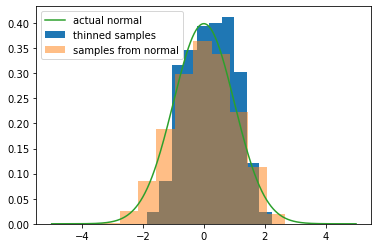

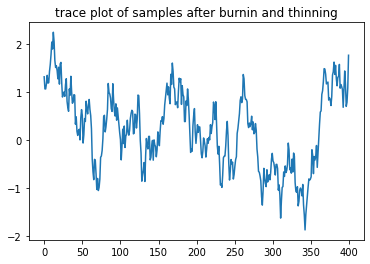

In [ ]:
tuning(1e-2, 20, -5, 1000)

The samples don't look converged based on the trace plot. The acceptance rate is zero, which is very surprising. There may be something wrong in the implementation.


**Exercise 6:** Empirically determine the effects of 
1. increasing/decreasing the number of leap-frog steps
2. increasing/decrasing the size of leap-frog steps

Are the effects as you anticipated in Exercise 4?

0
The acceptance rate is 0.0


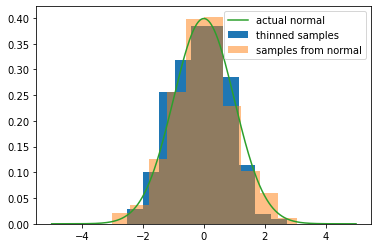

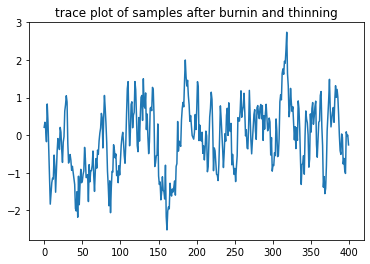

In [ ]:
# increased the number of steps
tuning(1e-2, 40, -5, 1000)

0
The acceptance rate is 0.0


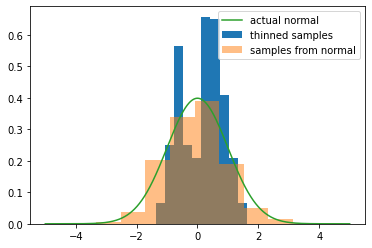

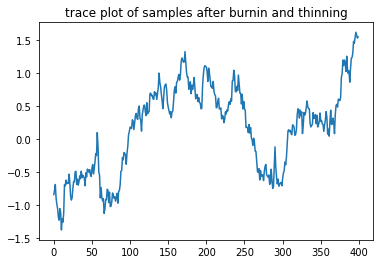

In [ ]:
# decreased number of steps
tuning(1e-2, 10, -5, 1000)

0
The acceptance rate is 0.0


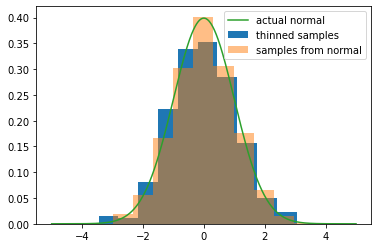

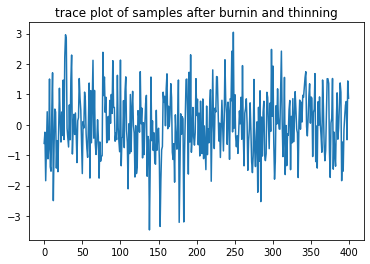

In [ ]:
# increase step size of frog leaps
tuning(1e-1, 20, -5, 1000)

0
The acceptance rate is 0.0


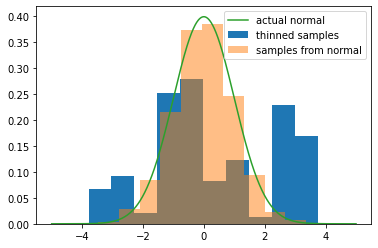

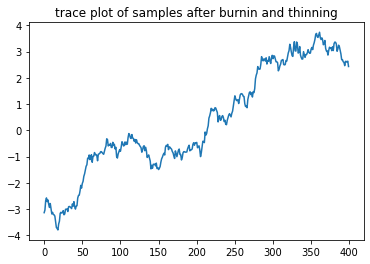

In [ ]:
# decrease step size of frog leaps
tuning(5e-3, 20, -5, 1000)

**Exercise 7:** Profile your HMC algorithm, which steps are the most computationally expensive and why? If the target distribution is the posterior distribution of a Bayesian model for $N$ number of observations, which part of the algorithm will scale poorly? Why?